In [1]:
import os
import numpy as np
from scipy import integrate, linalg
from matplotlib import pyplot as py
%matplotlib inline

In [2]:
naca_filepath = os.path.join('naca0012.dat')
with open(naca_filepath, 'r') as infile:
    x, y = np.loadtxt(infile, dtype=float, unpack=True)

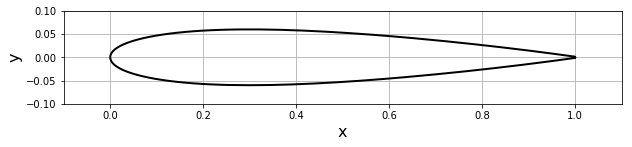

In [3]:
# plot geometry
width = 10
py.figure(figsize=(width, width))
py.grid()
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
py.plot(x, y, color='k', linestyle='-', linewidth=2)
py.axis('scaled', adjustable='box')
py.xlim(-0.1, 1.1)
py.ylim(-0.1, 0.1);

In [4]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2
        self.length = np.sqrt((xb - xa)**2 + (yb - ya)**2)
        
        if xb - xa <= 0.0:
            self.beta = np.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = np.pi + np.arccos(-(yb - ya) / self.length)
            
        if self.beta <= np.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
            
        self.sigma = 0.0
        self.vt = 0.0
        self.cp = 0.0

In [5]:
def define_panels(x, y, N=40):
    R = (x.max() - x.min()) / 2
    x_center = (x.max() + x.min()) / 2
    x_circle = x_center + R * np.cos(np.linspace(0.0, 2 * np.pi, N + 1))
    x_ends = np.copy(x_circle)
    y_ends = np.empty_like(x_ends)
    
    x, y = np.append(x, x[0]), np.append(y, y[0])
    
    I = 0
    for i in range(N):
        while I < len(x) - 1:
            if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I+1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I+1] - y[I]) / (x[I+1] - x[I])
        b = y[I+1] - a * x[I + 1]
        y_ends[i] = a * x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    panels = np.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
        
    return panels

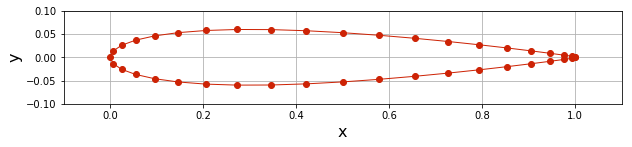

In [6]:
N = 40
panels = define_panels(x, y, N)
width = 10
py.figure(figsize=(width, width))
py.grid()
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
py.plot(np.append([panel.xa for panel in panels], panels[0].xa),
            np.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
py.axis('scaled', adjustable='box')
py.xlim(-0.1, 1.1)
py.ylim(-0.1, 0.1);

In [7]:
class Freestream:
    def __init__(self, u_inf=1.0, alpha=0.0):
        self.u_inf = u_inf
        self.alpha = np.radians(alpha)

In [8]:
freestream = Freestream(u_inf=1.0, alpha=4.0)

In [9]:
def integral(x, y, panel, dxdk, dydk):
    def integrand(s):
        return (((x - (panel.xa - np.sin(panel.beta) * s)) * dxdk +
                 (y - (panel.ya + np.cos(panel.beta) * s)) * dydk) /
                ((x - (panel.xa - np.sin(panel.beta) * s))**2 + 
                 (y - (panel.ya + np.cos(panel.beta) * s))**2))
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [10]:
def source_contribution_normal(panels):
    A = np.empty((panels.size, panels.size), dtype=float)
    np.fill_diagonal(A, 0.5)
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / np.pi * integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 np.cos(panel_i.beta),
                                                 np.sin(panel_i.beta))
    return A

In [11]:
def vortex_contribution_normal(panels):
    A = np.empty((panels.size, panels.size), dtype=float)
    np.fill_diagonal(A, 0.0)
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / np.pi * integral(panel_i.xc, panel_i.yc,
                                                  panel_j,
                                                  np.sin(panel_i.beta),
                                                  -np.cos(panel_i.beta))
    return A

In [12]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

In [13]:
def kutta_condition(A_source, B_vortex):
    b = np.empty(A_source.shape[0] + 1, dtype=float)
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    b[-1] = -np.sum(A_source[0,:] + A_source[-1,:])
    return b

In [14]:
def build_singularity_matrix(A_source, B_vortex):
    A = np.empty((A_source.shape[0] + 1, A_source.shape[1] + 1), dtype = float)
    A[:-1, :-1] = A_source
    A[:-1, -1] = np.sum(B_vortex, axis=1)
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

In [15]:
def build_freestream_rhs(panels, freestream):
    b = np.empty(panels.size + 1, dtype=float)
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    b[-1] = -freestream.u_inf * (np.sin(freestream.alpha - panels[0].beta) +
                                 np.sin(freestream.alpha - panels[-1].beta))
    return b

In [16]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)

In [17]:
strengths = np.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = strengths[i]
    
gamma = strengths[-1]

In [18]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    A = np.empty((panels.size, panels.size + 1), dtype=float)
    A[:, :-1] = B_vortex
    A[:, -1] = -np.sum(A_source, axis=1)
    b = freestream.u_inf * np.sin([freestream.alpha - panel.beta
                                   for panel in panels])
    strengths = np.append([panel.sigma for panel in panels], gamma)
    tangential_velocities = np.dot(A, strengths) + b
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [19]:
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)

In [20]:
def compute_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2

In [21]:
compute_pressure_coefficient(panels, freestream)

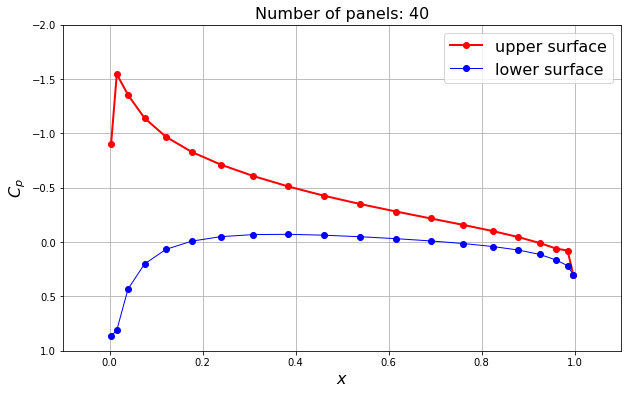

In [22]:
# plot surface pressure coefficient
py.figure(figsize=(10, 6))
py.grid()
py.xlabel('$x$', fontsize=16)
py.ylabel('$C_p$', fontsize=16)
py.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
py.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
py.legend(loc='best', prop={'size':16})
py.xlim(-0.1, 1.1)
py.ylim(1.0, -2.0)
py.title('Number of panels: {}'.format(panels.size), fontsize=16);

In [23]:
# calculate the accuracy
accuracy = sum([panel.sigma * panel.length for panel in panels])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: 0.004606


In [24]:
c = abs(max(panel.xa for panel in panels) -
        min(panel.xa for panel in panels))
cl = (gamma * sum(panel.length for panel in panels) /
      (0.5 * freestream.u_inf * c))
print('lif coefficient: CL = {:0.3f}'.format(cl))

lif coefficient: CL = 0.506


In [25]:
def get_velocity_field(panels, freestream, X, Y):
    u = freestream.u_inf * np.cos(freestream.alpha) * np.ones_like(X, dtype=float)
    v = freestream.u_inf * np.sin(freestream.alpha) * np.ones_like(X, dtype=float)
    
    vec_integral = np.vectorize(integral)
    for panel in panels:
        u += ((panel.sigma / (2.0 * np.pi) * vec_integral(X, Y, panel, 1.0, 0.0))
              + gamma / (2 *np.pi) * vec_integral(X, Y, panel, 1.0, 0.0))
        v += ((panel.sigma / (2.0 * np.pi) * vec_integral(X, Y, panel, 0.0, 1.0))
              - gamma / (2*np.pi) * vec_integral(X, Y, panel, 0.0, 1.0))
        
        return u, v

In [29]:
# define a mesh grid
nx, ny = 20, 20  # number of points in the x and y directions
x_start, x_end = -1.0, 2.0
y_start, y_end = -0.3, 0.3
X, Y = np.meshgrid(np.linspace(x_start, x_end, nx),
                      np.linspace(y_start, y_end, ny))

# compute the velocity field on the mesh grid
u, v = get_velocity_field(panels, freestream, X, Y)
alpha = 4

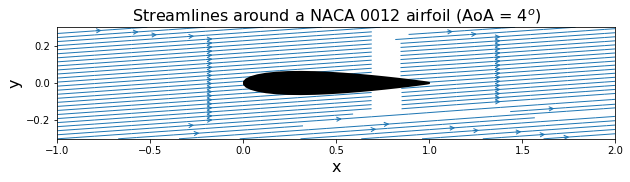

In [30]:
# plot the velocity field
width = 10
py.figure(figsize=(width, width))
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
py.streamplot(X, Y, u, v,
                  density=1, linewidth=1, arrowsize=1, arrowstyle='->')
py.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
py.axis('scaled', adjustable='box')
py.xlim(x_start, x_end)
py.ylim(y_start, y_end)
py.title('Streamlines around a NACA 0012 airfoil (AoA = ${}^o$)'.format(alpha),
             fontsize=16);